In [1]:
from glob import glob
import numpy as np
import pyabf
import matplotlib.pyplot as plt
import matplotlib as mp
from open_abf import *
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from scipy.optimize import leastsq
import filtering
%matplotlib widget

In [2]:
pathToData = "/home/alan/Documents/LAB/CSHL/Data/Local Field Potentials Recordings/"
files = glob(pathToData+"*.abf")
files

['/home/alan/Documents/LAB/CSHL/Data/Local Field Potentials Recordings/24615007.abf',
 '/home/alan/Documents/LAB/CSHL/Data/Local Field Potentials Recordings/24615004.abf',
 '/home/alan/Documents/LAB/CSHL/Data/Local Field Potentials Recordings/24615005.abf',
 '/home/alan/Documents/LAB/CSHL/Data/Local Field Potentials Recordings/24615010.abf',
 '/home/alan/Documents/LAB/CSHL/Data/Local Field Potentials Recordings/24615006.abf',
 '/home/alan/Documents/LAB/CSHL/Data/Local Field Potentials Recordings/24615008.abf',
 '/home/alan/Documents/LAB/CSHL/Data/Local Field Potentials Recordings/24615002.abf',
 '/home/alan/Documents/LAB/CSHL/Data/Local Field Potentials Recordings/24615009.abf',
 '/home/alan/Documents/LAB/CSHL/Data/Local Field Potentials Recordings/24615003.abf',
 '/home/alan/Documents/LAB/CSHL/Data/Local Field Potentials Recordings/24615001.abf']

In [3]:
get_protocol(files)

['None',
 'None',
 'None',
 'None',
 'None',
 'None',
 'None',
 'None',
 'None',
 'None']

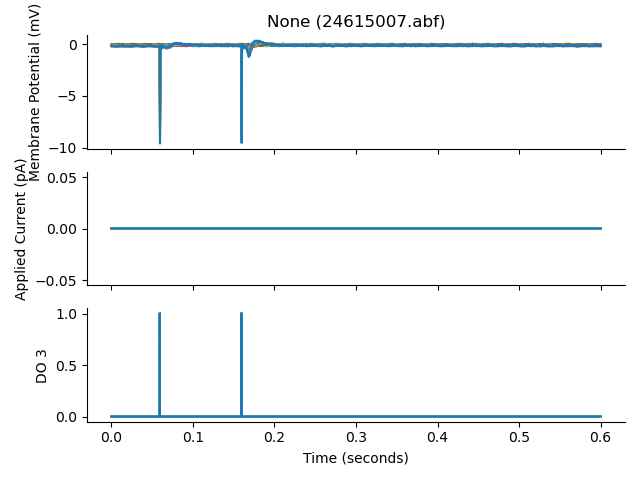

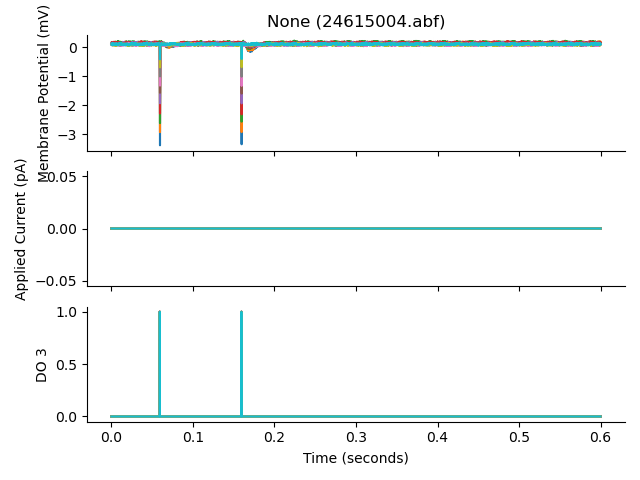

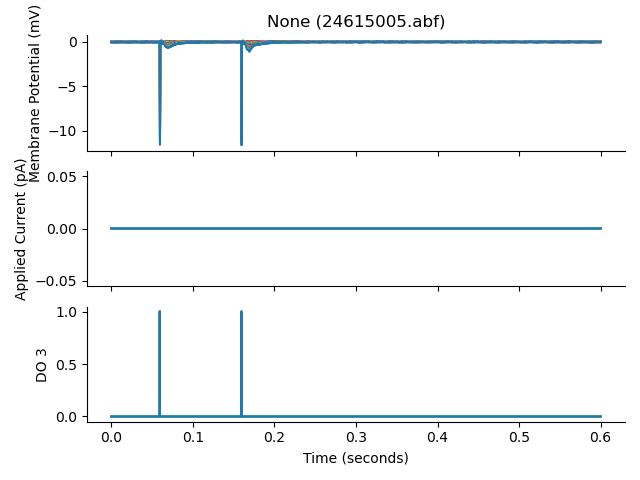

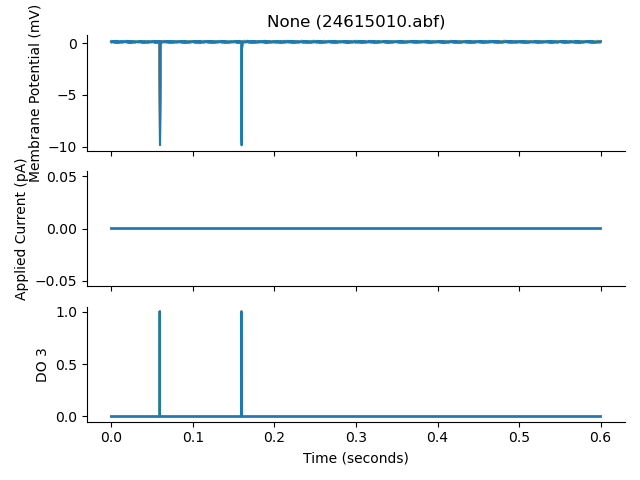

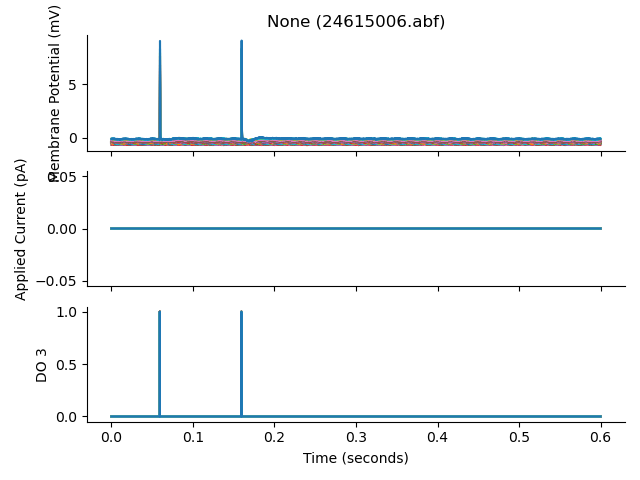

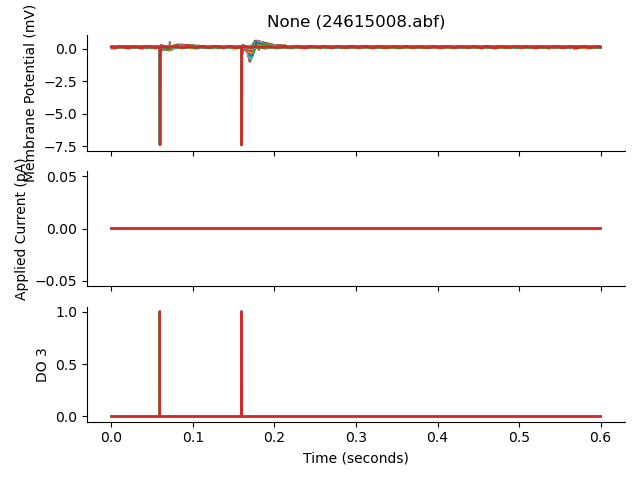

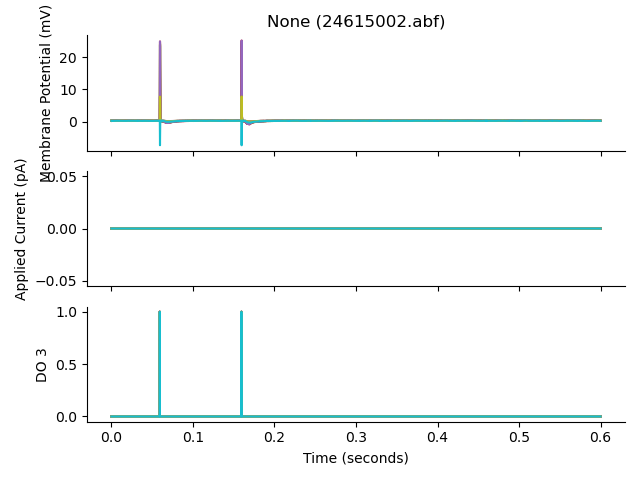

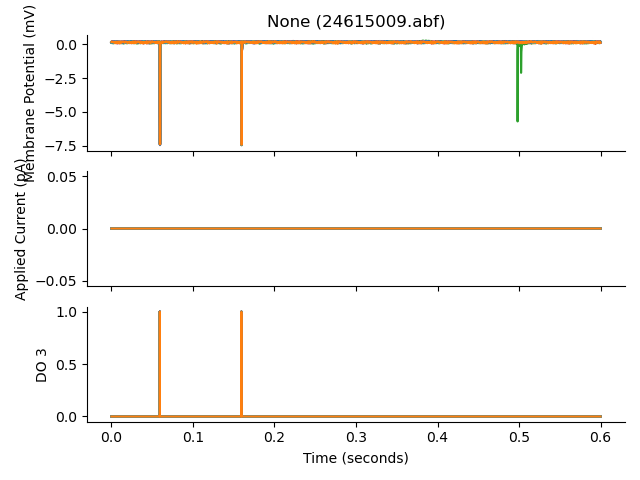

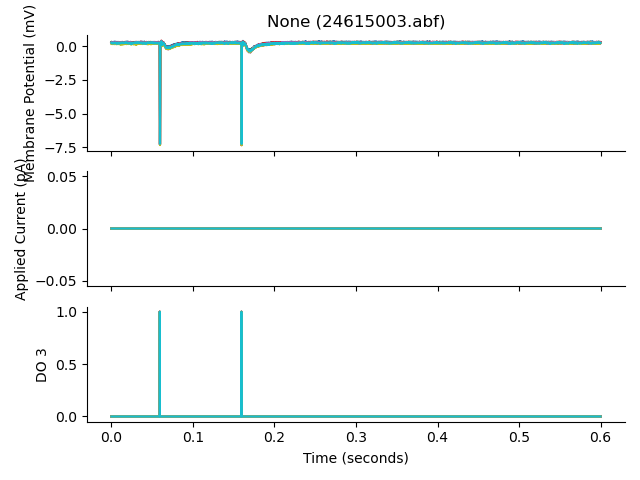

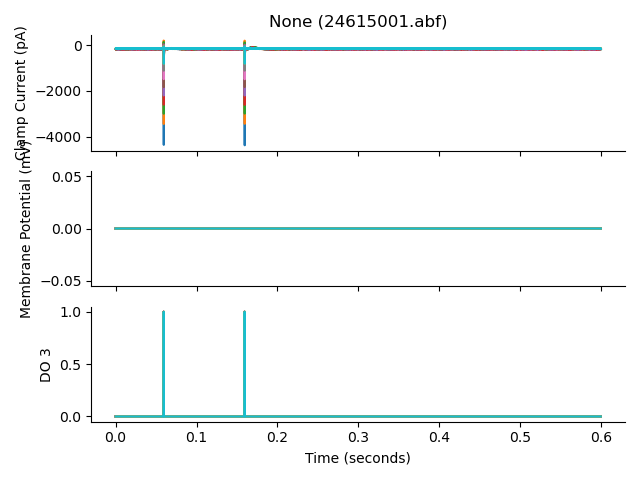

In [4]:
for f in files:
    plot_swps_DO(f,[3])

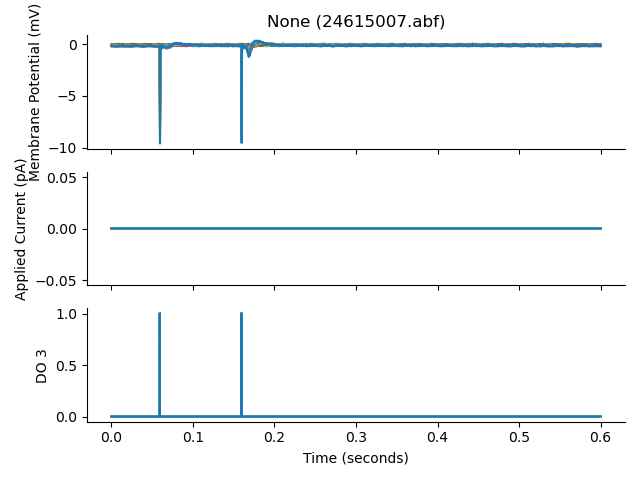

In [5]:
plt.close('all')
f = files[0]
plot_swps_DO(f,[3])

In [6]:
def findstim(do,sr):
    ones = np.where(do)[1]
    stim = [ones[0]]
    on = stim[0]
    for one in ones[1:]:
        if (one-on) > 1:
            stim.append(one)
        on = one
    return np.array(stim)/sr

In [7]:
f = files[0]    
swps,DO,swp_time,sr = get_sweeps_DO(f,[3])
stims = findstim(DO[0],sr)
print(stims*1e3) ## stim times in ms

[ 59.35 159.45]


In [8]:
delta_stim = stims[1:] - stims[:-1]
delta_stim[0]*1e3 ## in ms

100.10000000000001

In [9]:
# Time in seconds for components of response:
baseline = 10e-3
stim_artefact = 2e-3
AP_volley = 2.5e-3
EPSP =  40e-3
# for each stim extract the response
art = []
vol = []
res = []
for stim in stims:
    b = np.mean(swp_window(swps,stim-baseline,stim,sr))
    art.append(swp_window(swps,stim,stim+stim_artefact,sr) - b)
    start = stim+stim_artefact
    vol.append(swp_window(swps,start,start+AP_volley,sr) - b)
    start += AP_volley
    res.append(swp_window(swps,start,start+EPSP,sr) - b)
    
response = np.array(res)
volley = np.array(vol)
artefact = np.array(art)

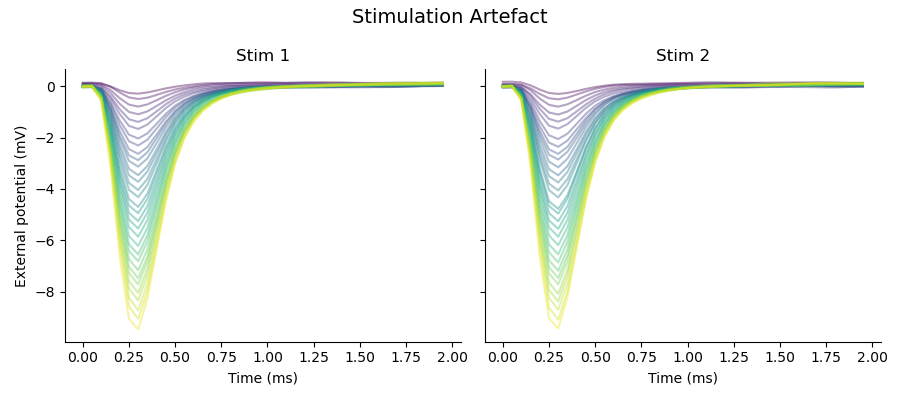

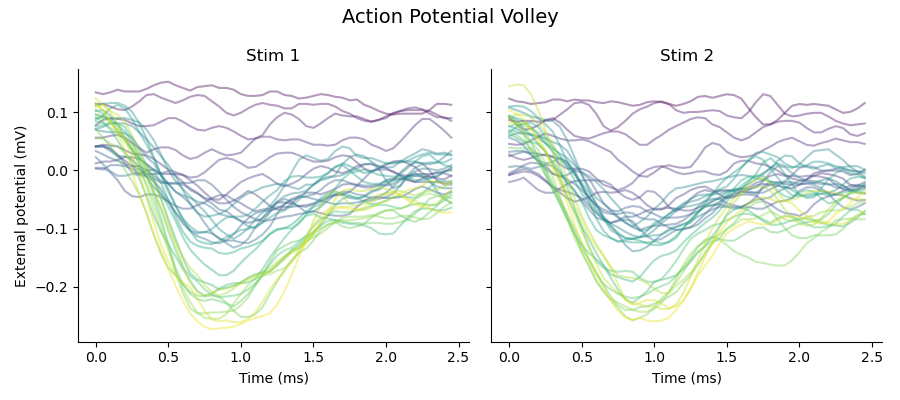

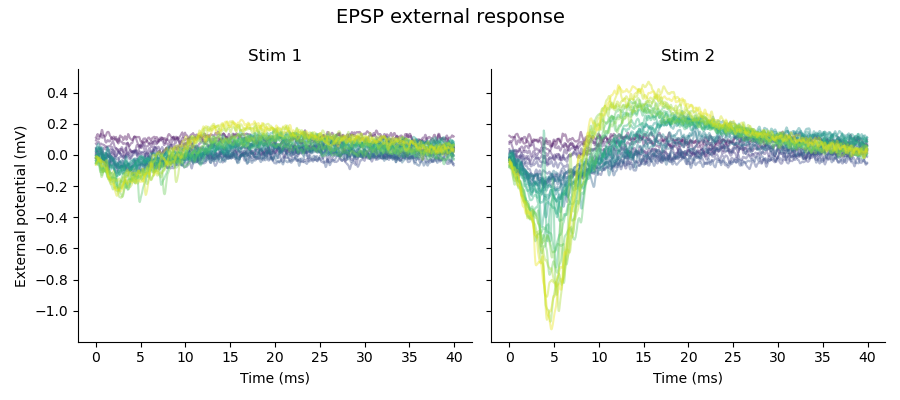

In [10]:
plt.close('all')
## Artefact
cmap = mp.colormaps['viridis']
figsize = (9,4)
fontsize = 14
alpha = 0.4
fig,ax = plt.subplots(1,2,sharex=True,sharey=True,figsize=figsize)
fig.suptitle('Stimulation Artefact', fontsize=fontsize)
ax[0].set_ylabel('External potential (mV)')
for i,art in enumerate(artefact):
    ax[i].set_title(f'Stim {i+1}')
    ax[i].set_xlabel('Time (ms)')
    ax[i].spines['right'].set_visible(False)
    ax[i].spines['top'].set_visible(False)
    time = np.arange(len(art[0]))/sr
    for j,swp in enumerate(art):
        color = cmap(j/len(art))[:-1]
        ax[i].plot(time*1e3,swp,color=color,alpha=alpha)
fig.tight_layout()
## Volley
fig,ax = plt.subplots(1,2,sharex=True,sharey=True,figsize=figsize)
fig.suptitle('Action Potential Volley', fontsize=fontsize)
ax[0].set_ylabel('External potential (mV)')
for i,vol in enumerate(volley):
    ax[i].set_title(f'Stim {i+1}')
    ax[i].set_xlabel('Time (ms)')
    ax[i].spines['right'].set_visible(False)
    ax[i].spines['top'].set_visible(False)
    time = np.arange(len(vol[0]))/sr
    for j,swp in enumerate(vol):
        color = cmap(j/len(vol))[:-1]
        ax[i].plot(time*1e3,swp,color=color,alpha=alpha)
fig.tight_layout()
## Response
fig,ax = plt.subplots(1,2,sharex=True,sharey=True,figsize=figsize)
fig.suptitle('EPSP external response', fontsize=fontsize)
ax[0].set_ylabel('External potential (mV)')
for i,res in enumerate(response):
    ax[i].set_title(f'Stim {i+1}')
    ax[i].set_xlabel('Time (ms)')
    ax[i].spines['right'].set_visible(False)
    ax[i].spines['top'].set_visible(False)
    time = np.arange(len(res[0]))/sr
    for j,swp in enumerate(res):
        color = cmap(j/len(res))[:-1]
        ax[i].plot(time*1e3,swp,color=color,alpha=alpha)
fig.tight_layout()

In [90]:
## Now lets extract amplitudes
## AP Volley
amp_volley = []
for vol in volley:
    amp_volley.append(np.min(vol,axis=1))
amp_volley = np.array(amp_volley)
## EPSP response
amp_response_min = []
amp_response_max = []
for res in response:
    amp_response_min.append(np.min(res,axis=1))
    amp_response_max.append(np.max(res,axis=1))
amp_response_min = np.array(amp_response_min)
amp_response_max = np.array(amp_response_max)

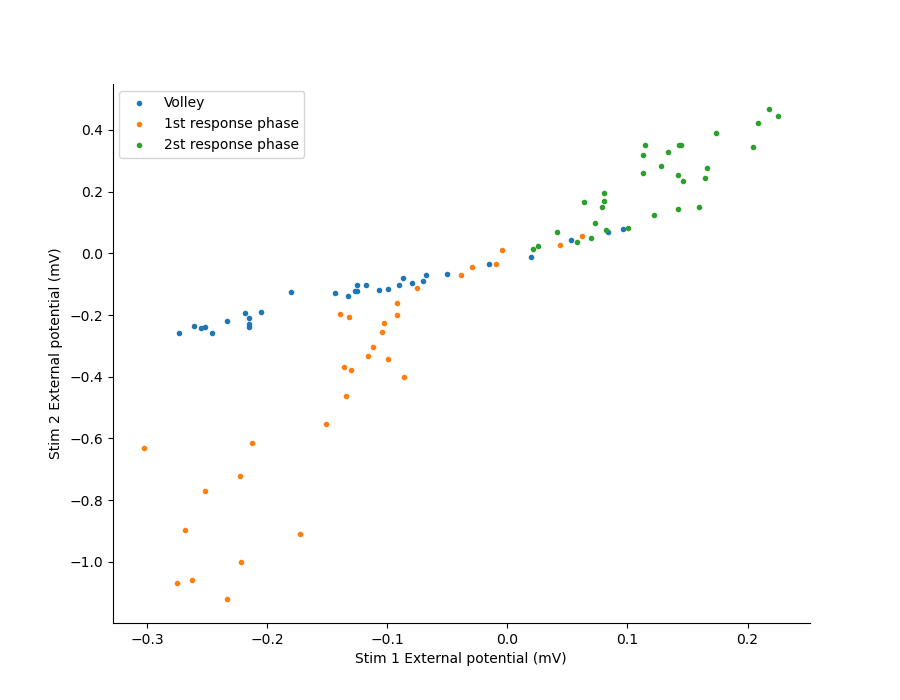

In [99]:
cmap = mp.colormaps['viridis']
figsize = (9,7)
fontsize = 12
alpha = 0.4
## Volley
fig,ax = plt.subplots(figsize=figsize)
ax.set_xlabel('Stim 1 External potential (mV)')
ax.set_ylabel('Stim 2 External potential (mV)')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.plot(amp_volley[0],amp_volley[1],".",label="Volley")
ax.plot(amp_response_min[0],amp_response_min[1],".",label="1st response phase")
ax.plot(amp_response_max[0],amp_response_max[1],".",label="2st response phase")
ax.legend()

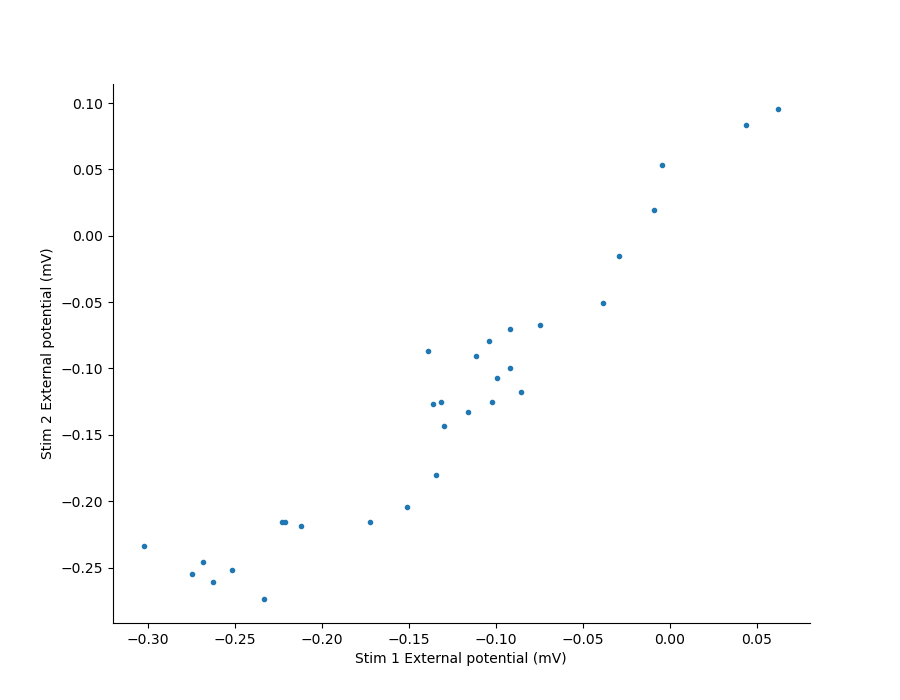

In [101]:
cmap = mp.colormaps['viridis']
figsize = (9,7)
fontsize = 12
alpha = 0.4
## Volley
fig,ax = plt.subplots(figsize=figsize)
ax.set_xlabel('Stim 1 External potential (mV)')
ax.set_ylabel('Stim 2 External potential (mV)')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.plot(amp_response_min[0],amp_volley[0],".")

In [ ]:
ax.plot(amp_response_min[0],amp_volley[0],".")